In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import healpy as hp
from tqdm import tqdm
import pickle as pl
sys.path.append('../')
import os
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
# from dance.delens import Delens
# from dance.utils import bin_cmb_spectrum
# from dance.sampling import Likelihood
from dance.utils import plot_posterior

In [6]:
# basedir = '/mnt/sdceph/users/alonappan/DANCE_debug'
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["cm"],
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "text.latex.preamble": r"\usepackage{amsmath, amssymb}",
})
datadir = '/Users/antoidicherianlonappan/Workspace/DelensCoBi/data'

In [7]:
fname = f'{datadir}/posterior.pkl'
if os.path.isfile(fname):
    data = pl.load(open(fname,'rb'))
    lowl_samps = data['lowl_samps']
    lowl_labels = data['lowl_labels']
    highl_samps = data['highl_samps']
    highl_labels = data['highl_labels']
else:
    data = {}
    d_stategy1 = Delens(basedir,2048,6,beta=0.35,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,verbose=0)
    d_stategy2 = Delens(basedir,2048,6,beta=0.35,lmin_ivf=200,lmax_ivf=4096,lmax_qlm=4096,verbose=0)
    lh_stategy1_lowl = Likelihood(d_stategy1,lmax=200,debias=False)
    lh_stategy1_lowl_debias = Likelihood(d_stategy1,lmax=200,debias=True)
    lh_stategy1_lowl_theory = Likelihood(d_stategy1,lmax=200,debias=True,gauss=True)
    lh_stategy2_lowl = Likelihood(d_stategy2,lmax=200,debias=False)


    lh_stategy1_highl = Likelihood(d_stategy1,lmax=1000,debias=True)
    lh_stategy1_highl_theory = Likelihood(d_stategy1,lmax=1000,debias=True,gauss=True)
    lensed_samp_lowl = lh_stategy1_lowl.get_lensed_samp(getdist=False)
    delensed_s1_samp_lowl_biased = lh_stategy1_lowl.get_delensed_samp(getdist=False,debias=False)
    delensed_s1_samp_lowl_debiased = lh_stategy1_lowl_debias.get_delensed_samp(getdist=False,debias=True)
    delensed_samp_lowl_theory = lh_stategy1_lowl_theory.get_delensed_samp(getdist=False,debias=False)
    delensed_s2_samp_lowl_unbiased = lh_stategy2_lowl.get_delensed_samp(getdist=False,debias=False)
    lowl_samps = [lensed_samp_lowl,delensed_s1_samp_lowl_biased,delensed_s1_samp_lowl_debiased,delensed_samp_lowl_theory,delensed_s2_samp_lowl_unbiased]
    lowl_labels = ['Lensed','Delensed (Biased)','Delensed (S1,Debiased)', 'Delensed (Gaussian)', 'Delensed (S2, Unbiased)']
    data['lowl_samps'] = lowl_samps
    data['lowl_labels'] = lowl_labels

    lensed_samp_highl = lh_stategy1_highl.get_lensed_samp(getdist=False)
    delensed_s1_samp_highl_debiased = lh_stategy1_highl.get_delensed_samp(getdist=False,debias=True)
    delensed_samp_highl_theory = lh_stategy1_highl_theory.get_delensed_samp(getdist=False,debias=False)
    highl_samps = [lensed_samp_highl,delensed_s1_samp_highl_debiased,delensed_samp_highl_theory]
    highl_labels = ['Lensed','Delensed (S1, Debiased)', 'Delensed (Gaussian)']
    data['highl_samps'] = highl_samps
    data['highl_labels'] = highl_labels
    pl.dump(data,open(fname,'wb'))

In [8]:
lowl_samps[2],lowl_samps[-1] = lowl_samps[-1],lowl_samps[2]
lowl_labels[2],lowl_labels[-1] = 'Delensed (S1, Unbiased)', 'Delensed (S2, Debiased)'

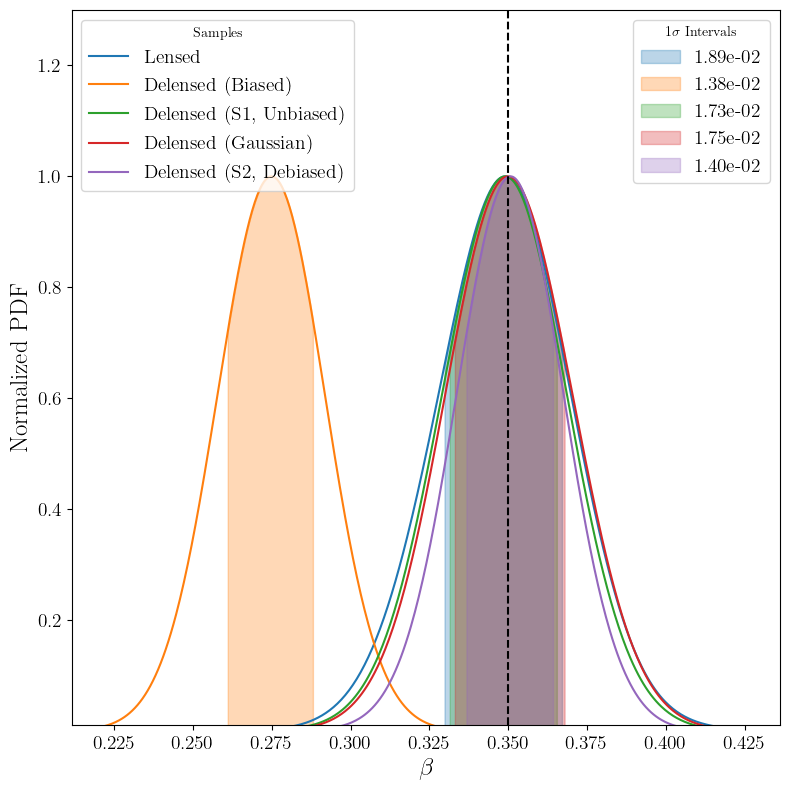

In [10]:
plot_posterior(lowl_samps,r'$\beta$',lowl_labels,truth=0.35,backend='sklearn',bandwidth=0.01,sigma_line=False,fill_alpha=0.3,figsize=(8,8))

In [11]:
highl_labels[1] = 'Delensed (S2, Debiased)'

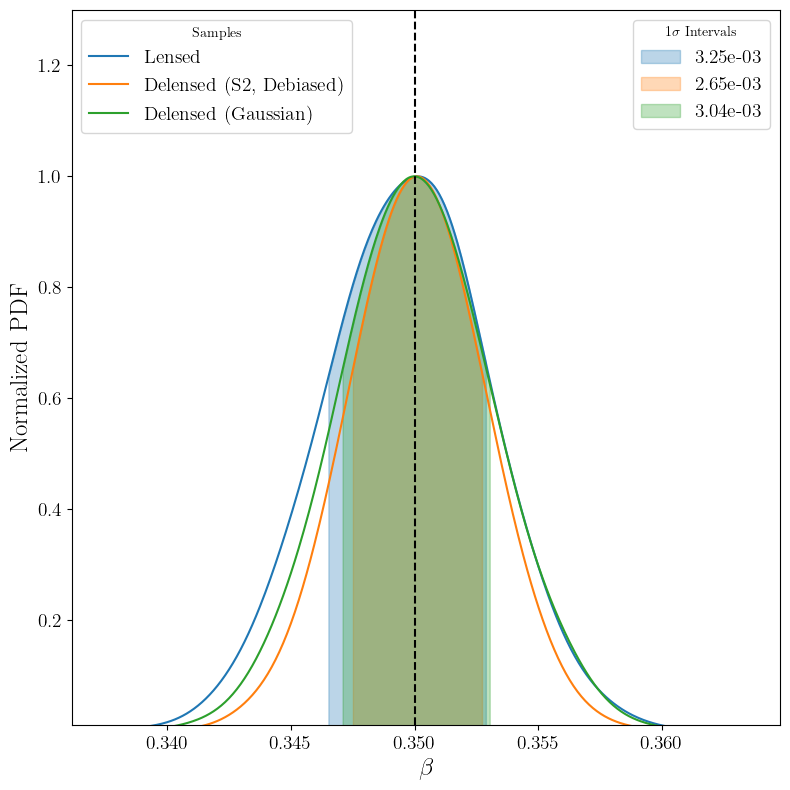

In [12]:
plot_posterior(highl_samps,r'$\beta$',highl_labels,truth=0.35,backend='sklearn',bandwidth=0.001,sigma_line=False,fill_alpha=0.3,figsize=(8,8))

In [13]:
fname = f'{datadir}/cls_lens_delens.pkl'
if os.path.isfile(fname):
    data = pl.load(open(fname,'rb'))
    bias = data['bias']
    b = data['b']
    lens_array = data['lens']
    delens_theory_array = data['delens_theory']
    delens_recon_biased = data['delens']
    delens_recon_unbiased = data['delens_unbiased']
    db = b * (b + 1) / (2 * np.pi)
    eb_signal = data['eb_signal']
    l = data['l']
    dl = data['dl']
else:
    Data = {}
    data = d_stategy1.get_data(debias=True)
    datas2 = d_stategy2.get_data(debias=False)
    bias = data['bias']
    b = data['b']
    lens_array = data['lens']
    delens_theory_array = data['delens_theory']
    delens_recon_biased = data['delens']
    delens_recon_unbiased = datas2['delens']
    db = b * (b + 1) / (2 * np.pi)
    eb_signal =d_stategy1.recon.wf.cmb.get_cb_lensed_spectra(0.35,dl=False)['eb']
    l = np.arange(len(eb_signal))
    dl = l * (l+1) / (2 * np.pi)
    Data['bias'] = bias
    Data['b'] = b
    Data['lens'] = lens_array
    Data['delens_theory'] = delens_theory_array
    Data['delens'] = delens_recon_biased
    Data['delens_unbiased'] = delens_recon_unbiased
    Data['eb_signal'] = eb_signal
    Data['l'] = l
    Data['dl'] = dl
    pl.dump(Data,open(fname,'wb'))

Text(0, 0.5, '$\\frac{\\ell(\\ell +1)}{2 \\pi} C_{\\ell}^{EB}$')

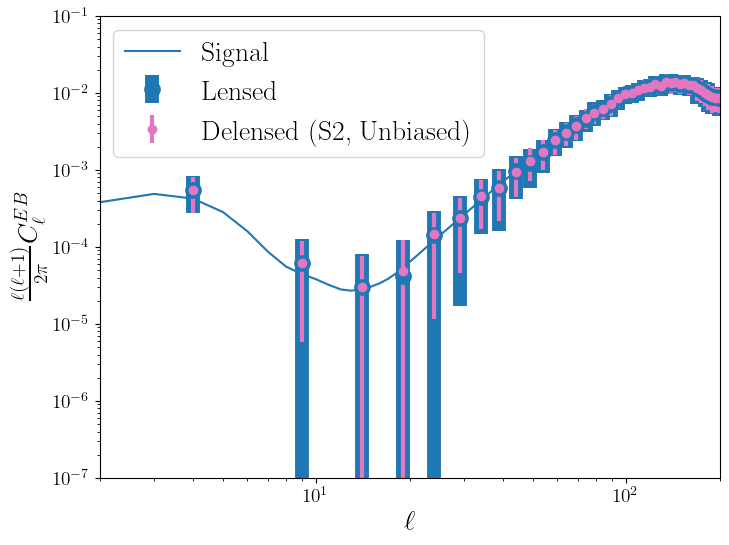

In [ ]:
plt.figure(figsize=(8,6))
plt.errorbar(b,lens_array.mean(axis=0)*db,yerr=lens_array.std(axis=0)*db,fmt='o',label='Lensed',ms=11,elinewidth=10,color='C0')
plt.loglog(dl*eb_signal,label='Signal')
#plt.errorbar(b,(delens_recon_biased.mean(axis=0)+bias)*db,yerr=delens_recon_biased.std(axis=0)*db,fmt='o',label='Delensed (S1, Debiased)',ms=6,elinewidth=3,color='C13')
plt.errorbar(b,delens_recon_unbiased.mean(axis=0)*db,yerr=delens_recon_unbiased.std(axis=0)*db,fmt='o',label='Delensed (S2, Unbiased)',ms=6,elinewidth=3,color='C14')
#plt.errorbar(b,delens_theory_array.mean(axis=0)*db,yerr=delens_theory_array.std(axis=0)*db,fmt='o',label='Delensed (Gaussian)',ms=6,elinewidth=3,color='C6')
plt.xlim(2,200)
plt.ylim(1e-7,1e-1)
plt.legend(fontsize=20)
plt.xlabel(r'$\ell$',fontsize=20)
plt.ylabel(r'$\frac{\ell(\ell +1)}{2 \pi} C_{\ell}^{EB}$',fontsize=20)
#plt.savefig('delensed_eb.pdf',bbox_inches='tight',dpi=300)

In [15]:
def get_dist_data(lmax):
    d_sp_1 = Delens(basedir,2048,1,beta=0.35,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,verbose=0,special_case=True)
    d_sp_2 = Delens(basedir,2048,2,beta=0.35,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,verbose=0,special_case=True)
    lh_sp_1_qe = Likelihood(d_sp_1,lmax=lmax,iter=False)
    lh_sp_2_qe = Likelihood(d_sp_2,lmax=lmax,iter=False)
    lh_sp_1_i = Likelihood(d_sp_1,lmax=lmax,iter=True)
    lh_sp_2_i = Likelihood(d_sp_2,lmax=lmax,iter=True)
    data_imp = {}
    if lmax < 500:
        data_imp[6] = {}
        data_imp[6]['l'] = [lh_stategy1_lowl.get_lensed_samp(getdist=False).mean(axis=0),lh_stategy1_lowl.get_lensed_samp(getdist=False).std(axis=0)]
        data_imp[6]['d_qe'] = [lh_stategy1_lowl.get_delensed_samp(getdist=False,debias=True).mean(axis=0),lh_stategy1_lowl.get_delensed_samp(getdist=False,debias=True).std(axis=0)]
        data_imp[6]['d_qe_th'] = [lh_stategy1_lowl_theory.get_delensed_samp(getdist=False,debias=False).mean(axis=0),lh_stategy1_lowl_theory.get_delensed_samp(getdist=False,debias=False).std(axis=0)]
    else:
        data_imp[6] = {}
        data_imp[6]['l'] = [lh_stategy1_highl.get_lensed_samp(getdist=False).mean(axis=0),lh_stategy1_highl.get_lensed_samp(getdist=False).std(axis=0)]
        data_imp[6]['d_qe'] = [lh_stategy1_highl.get_delensed_samp(getdist=False,debias=True).mean(axis=0),lh_stategy1_highl.get_delensed_samp(getdist=False,debias=True).std(axis=0)]
        data_imp[6]['d_qe_th'] = [lh_stategy1_highl_theory.get_delensed_samp(getdist=False,debias=False).mean(axis=0),lh_stategy1_highl_theory.get_delensed_samp(getdist=False,debias=False).std(axis=0)]
    data_imp[2] = {}
    data_imp[2]['l'] = [lh_sp_2_qe.get_lensed_samp(getdist=False).mean(axis=0),lh_sp_2_qe.get_lensed_samp(getdist=False).std(axis=0)]
    data_imp[2]['d_qe'] = [lh_sp_2_qe.get_delensed_samp(getdist=False).mean(axis=0),lh_sp_2_qe.get_delensed_samp(getdist=False).std(axis=0)]
    data_imp[2]['d_i'] = [lh_sp_2_i.get_delensed_samp(getdist=False).mean(axis=0),lh_sp_2_i.get_delensed_samp(getdist=False).std(axis=0)]

    data_imp[1] = {}
    data_imp[1]['l'] = [lh_sp_1_qe.get_lensed_samp(getdist=False).mean(axis=0),lh_sp_1_qe.get_lensed_samp(getdist=False).std(axis=0)]
    data_imp[1]['d_qe'] = [lh_sp_1_qe.get_delensed_samp(getdist=False).mean(axis=0),lh_sp_1_qe.get_delensed_samp(getdist=False).std(axis=0)]
    data_imp[1]['d_i'] = [lh_sp_1_i.get_delensed_samp(getdist=False).mean(axis=0),lh_sp_1_i.get_delensed_samp(getdist=False).std(axis=0)]
    return data_imp

In [16]:
if os.path.isfile(f'{datadir}/dist_data.pkl'):
    data = pl.load(open(f'{datadir}/dist_data.pkl','rb'))
    data_200 = data[200]
    data_1000 = data[1000]
else:
    data = {}
    data_200 = get_dist_data(200)
    data_1000 = get_dist_data(1000)
    data[200] = data_200
    data[1000] = data_1000
    pl.dump(data,open(f'{datadir}/dist_data.pkl','wb'))

In [17]:
def manipulate_dict(data, remove=False, swap=False):
    for key, values in data.items():
        if swap and 'd_qe_th' in values:
            values['d_qe'] = values['d_qe_th']
            del values['d_qe_th']
        elif remove and 'd_qe_th' in values:
            del values['d_qe_th']
    return data

In [18]:
data_200 = manipulate_dict(data_200,remove=0,swap=1)
data_1000 = manipulate_dict(data_1000,remove=0,swap=1)

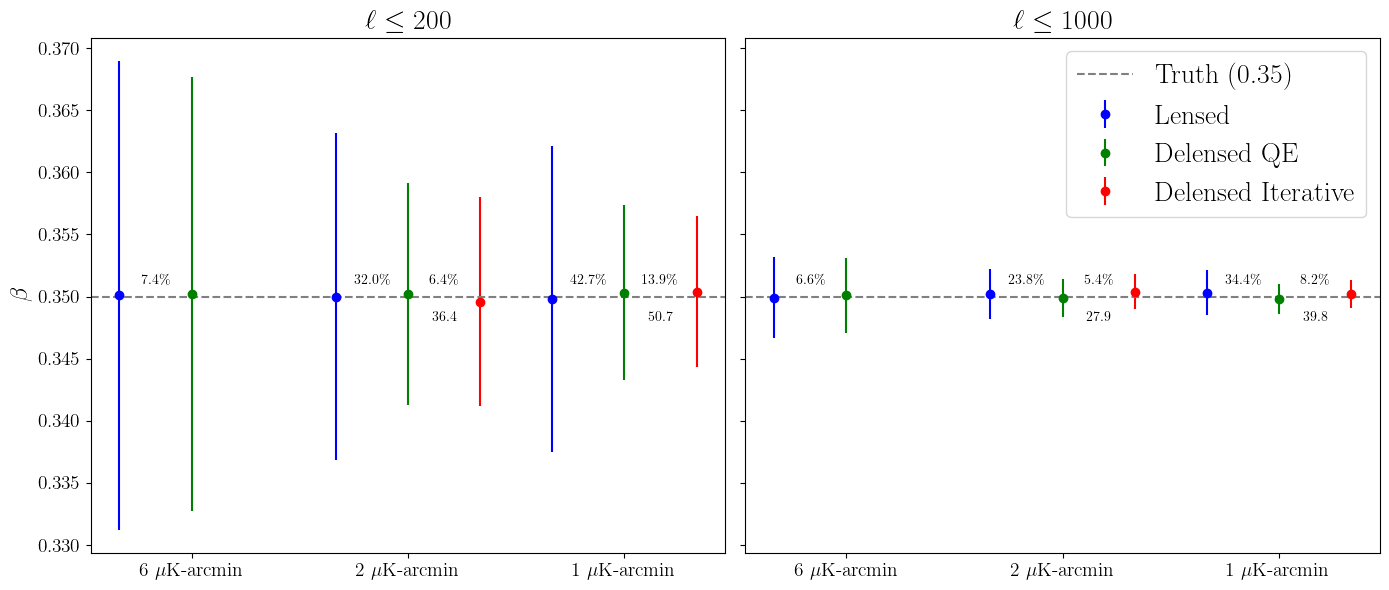

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
true_value = 0.35

colors = {'l': 'blue', 'd_qe': 'green', 'd_i': 'red'}
labels = {'l': 'Lensed', 'd_qe': 'Delensed QE', 'd_i': 'Delensed Iterative'}

for ax, (data, ell_range) in zip(axes, [(data_200, r'$\ell \leq 200$'), (data_1000, r'$\ell \leq 1000$')]):
    plotted_labels = set()

    for i, (noise, values) in enumerate(sorted(data.items(), reverse=True)):
        x_pos = i * 3  

        for j, key in enumerate(values.keys()):
            mean = values[key][0].item()  
            std = values[key][1].item()   


            label = labels[key] if labels[key] not in plotted_labels else None
            ax.errorbar(x_pos + j, mean, yerr=std, fmt='o', color=colors[key], label=label)
            plotted_labels.add(labels[key])
        

        sigma_improvement = []
        keys = list(values.keys())
        for k in range(len(keys) - 1):
            std_initial = values[keys[k]][1].item()
            std_next = values[keys[k + 1]][1].item()
            improvement = (1 - std_next / std_initial) * 100 
            sigma_improvement.append(improvement)
        

        for k, improvement in enumerate(sigma_improvement):
            corr = 0.001 
            ax.text(x_pos + k + 0.5, true_value + corr, f'{improvement:.1f}\%', fontsize=10, ha='center', color='black')

        # Compute sigma improvement between first (lensed) and last (delensed iterative)
        if 'd_i' in values:
            std_lensed = values['l'][1].item()
            std_iterative = values['d_i'][1].item()
            overall_improvement = (1 - std_iterative / std_lensed) * 100  # Convert to percentage

            # Add text annotation for improvement between first and last case (below the error bars)
            ax.text(x_pos + 1.5, true_value - 0.002, f'{overall_improvement:.1f}%', fontsize=10, ha='center', color='black')

    # Formatting
    ax.axhline(true_value, color='gray', linestyle='--', label='Truth (0.35)')
    ax.set_xticks([i * 3 + 1 for i in range(len(data))])
    ax.set_xticklabels([f'{noise} $\mu$K-arcmin' for noise in sorted(data.keys(), reverse=True)])
    ax.set_title(f'{ell_range}')

# Shared formatting
axes[0].set_ylabel(r'$\beta$')

# Place legend inside the second subplot (right side)
axes[1].legend(loc='upper right', fontsize=20)

# Adjust layout
plt.tight_layout()
#plt.savefig('dist_compare.pdf',bbox_inches='tight',dpi=300)